Loaded data with 2001 time steps

Training LSTM model...
Train data shape: (1798, 3, 1), (1798, 1)
Validation data shape: (200, 3, 1), (200, 1)
Epoch[1/50] | train loss: 0.699687, val loss: 0.760407 | lr: 0.010000
Epoch[26/50] | train loss: 0.473680, val loss: 0.580707 | lr: 0.010000

LSTM - Validation MSE: 144.850239


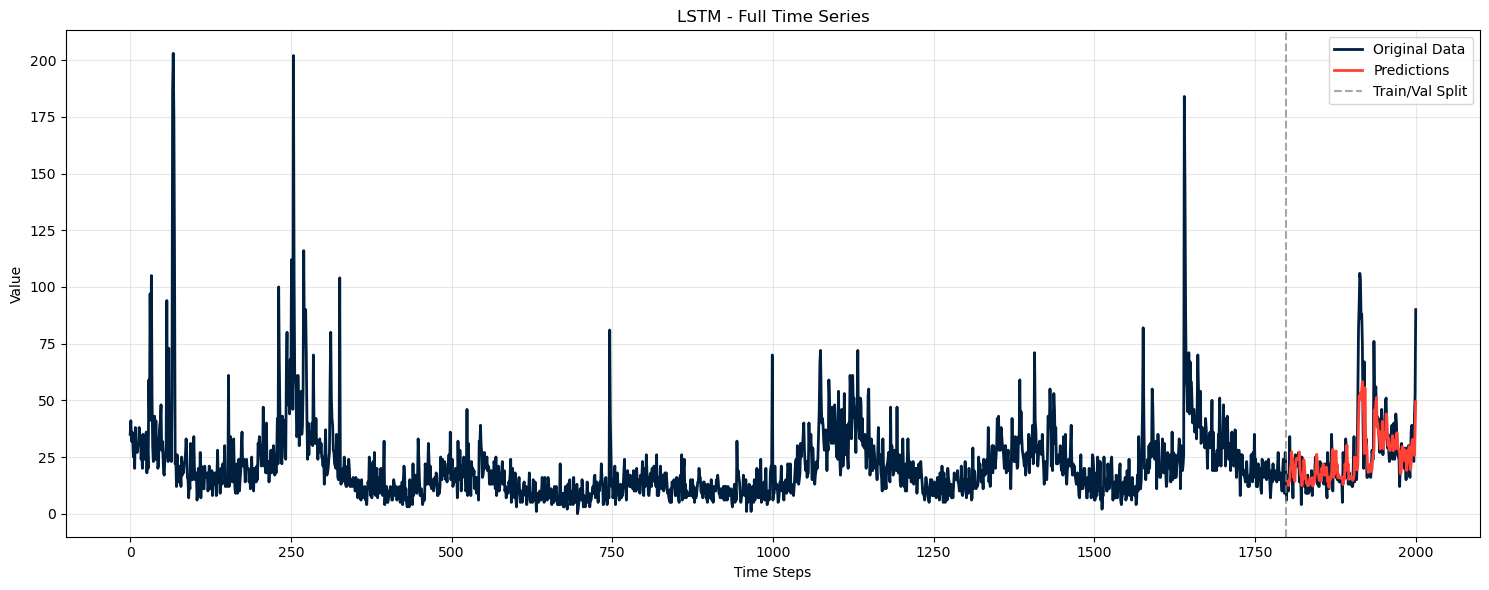


Training RW model...
Train data shape: (1798, 3, 1), (1798, 1)
Validation data shape: (200, 3, 1), (200, 1)
Epoch[1/50] | train loss: 0.686729, val loss: 0.652447 | lr: 0.010000
Epoch[26/50] | train loss: 0.480956, val loss: 0.503768 | lr: 0.010000

RW - Validation MSE: 134.925641


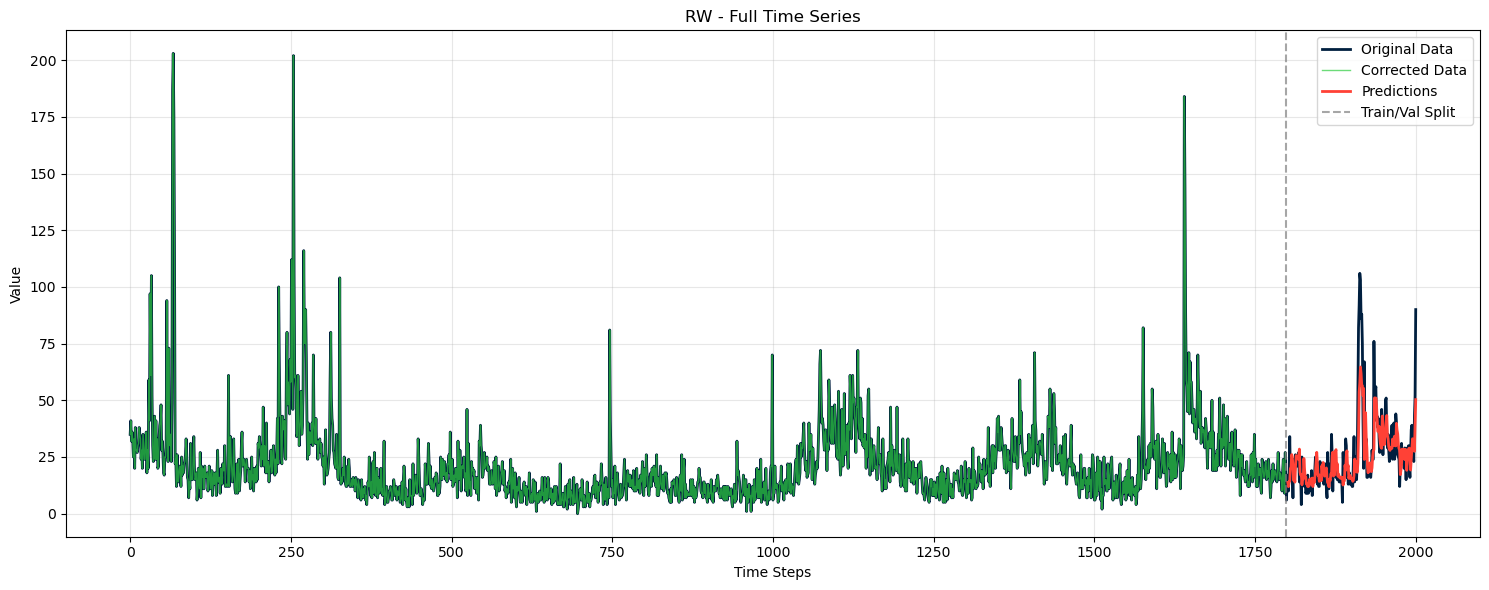


Training RW_RELU model...
Train data shape: (1798, 3, 1), (1798, 1)
Validation data shape: (200, 3, 1), (200, 1)
Epoch[1/50] | train loss: 0.651110, val loss: 0.636250 | lr: 0.010000
Epoch[26/50] | train loss: 0.493717, val loss: 0.480506 | lr: 0.010000

RW_RELU - Validation MSE: 112.380955


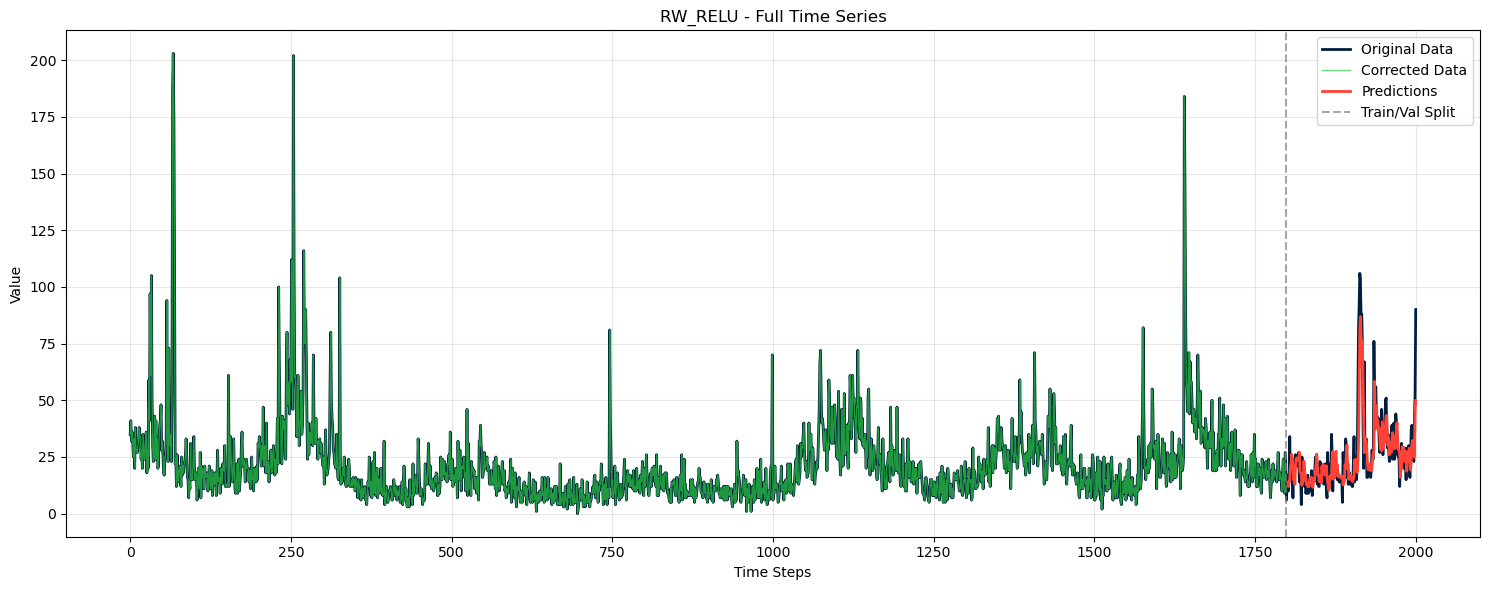


Training RW_SIGMOID model...
Train data shape: (1798, 3, 1), (1798, 1)
Validation data shape: (200, 3, 1), (200, 1)
Epoch[1/50] | train loss: 0.654568, val loss: 0.706861 | lr: 0.010000
Epoch[26/50] | train loss: 0.456571, val loss: 0.523413 | lr: 0.010000

RW_SIGMOID - Validation MSE: 120.965567


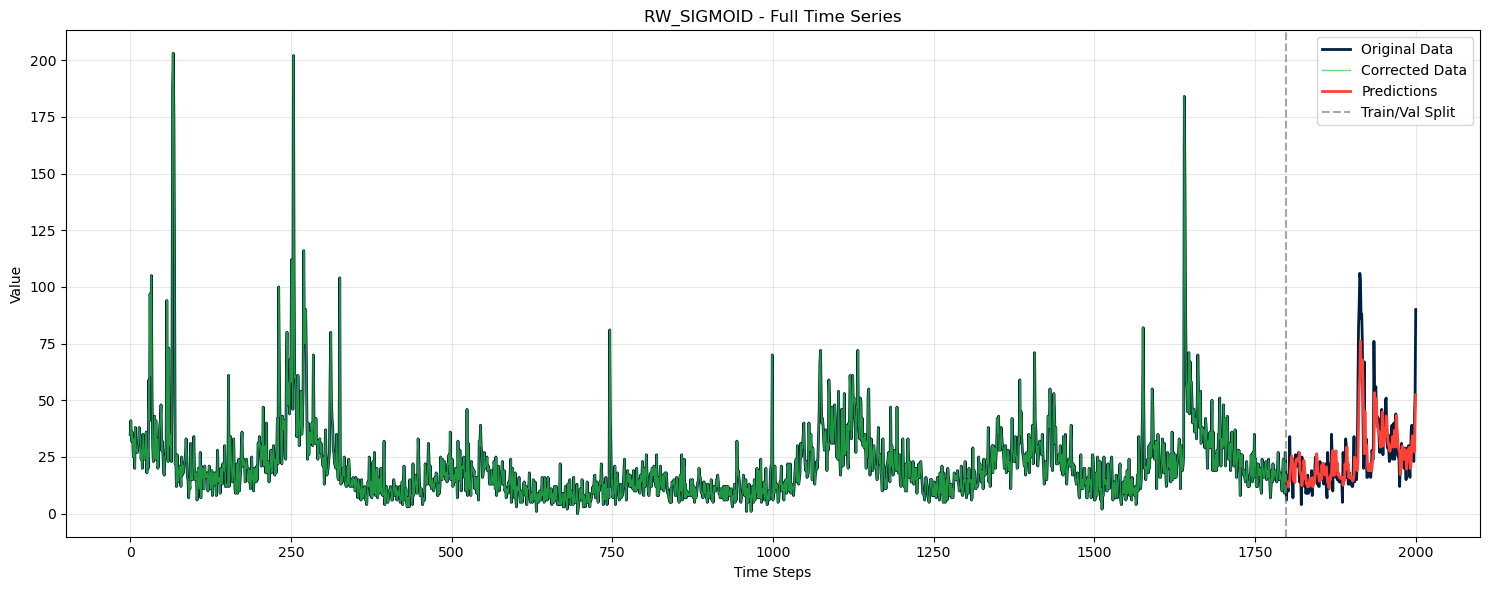


FINAL RESULTS COMPARISON
LSTM         - MSE: 144.850239
RW           - MSE: 134.925641
RW_RELU      - MSE: 112.380955
RW_SIGMOID   - MSE: 120.965567


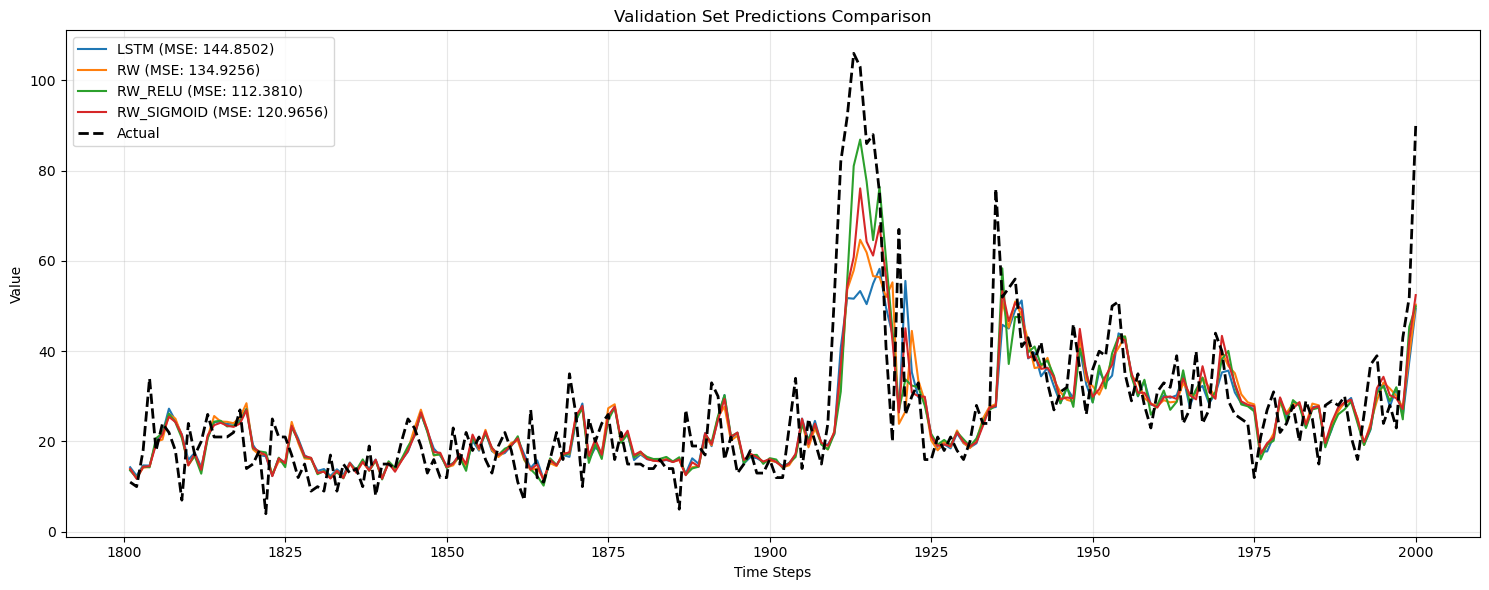

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(10)
np.random.seed(10)

class Config:
    """Configuration class for RW-LSTM model parameters"""
    def __init__(self):
        # Data parameters
        self.window_size = 3
        self.train_split_size = 0.9
        
        # Model parameters
        self.input_size = 1
        self.output_size = 1
        self.num_lstm_layers = 1
        self.lstm_size = 20
        self.dropout = 0.2
        
        # Training parameters
        self.device = "cpu"
        self.batch_size = 32
        self.num_epochs = 50
        self.learning_rate = 1e-2
        self.scheduler_step_size = 40
        
        # RW-LSTM specific parameters
        self.correction_rate = 0.001
        self.epoch_threshold = 45  # Start data correction after this epoch
        self.moving_avg_decay = 0.9  # Decay rate for moving average
        
        # Plotting parameters
        self.show_plots = True
        self.colors = {
            'actual': '#001f3f',
            'train': '#3D9970',
            'val': '#0074D9',
            'pred_train': '#3D9970',
            'pred_val': '#FF4136',
            'corrected': '#2ECC40'
        }

class SampleSpecificMovingAverage:
    """Maintains moving averages for each sample independently"""
    def __init__(self, num_samples, decay_rate=0.9):
        self.decay_rate = decay_rate
        self.num_samples = num_samples
        self.moving_avgs = {}  # Dict to store moving avg for each sample
        self.step_counts = {}  # Dict to store step count for each sample
    
    def update(self, sample_idx, new_values):
        """Update moving average for a specific sample"""
        if sample_idx not in self.moving_avgs:
            self.moving_avgs[sample_idx] = new_values.copy()
            self.step_counts[sample_idx] = 1
        else:
            self.step_counts[sample_idx] += 1
            self.moving_avgs[sample_idx] = (
                self.decay_rate * self.moving_avgs[sample_idx] + 
                (1 - self.decay_rate) * new_values
            )
        
        # Bias correction (like Adam optimizer)
        bias_correction = 1 - self.decay_rate ** self.step_counts[sample_idx]
        corrected_avg = self.moving_avgs[sample_idx] / bias_correction
        
        return corrected_avg
    
    def reset(self):
        """Reset all moving averages"""
        self.moving_avgs = {}
        self.step_counts = {}

class Normalizer:
    """Simple data normalizer using z-score normalization"""
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=0, keepdims=True)
        self.sd = np.std(x, axis=0, keepdims=True)
        return (x - self.mu) / self.sd

    def inverse_transform(self, x):
        return (x * self.sd) + self.mu

class TimeSeriesDataset(Dataset):
    """Custom dataset for time series data"""
    def __init__(self, x, y):
        # Expand dimensions for LSTM input [batch, sequence, features]
        x = np.expand_dims(x, 2)
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

class RWLSTMModel(nn.Module):
    """Read-Write LSTM Model that can modify input data during training"""
    
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, 
                          num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers * hidden_layer_size, output_size)
        self.init_weights()
      
    def init_weights(self):
        """Initialize LSTM weights using best practices"""
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Linear layer + activation
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)     

        # Reshape hidden states for final linear layer
        x = h_n.permute(1, 0, 2).reshape(batch_size, -1) 

        # Final prediction layer
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions

def prepare_windowed_data(data, window_size):
    """Create windowed sequences from time series data"""
    n_samples = len(data) - window_size
    X = np.zeros((n_samples, window_size))
    y = np.zeros((n_samples, 1))
    
    for i in range(n_samples):
        X[i] = data[i:i + window_size]
        y[i] = data[i + window_size]
    
    return X, y

def prepare_data(data, config):
    """Prepare training and validation datasets"""
    # Create windowed sequences
    X, y = prepare_windowed_data(data, config.window_size)
    
    # Split into train and validation
    split_idx = int(len(X) * config.train_split_size)
    
    X_train = X[:split_idx]
    y_train = y[:split_idx]
    X_val = X[split_idx:]
    y_val = y[split_idx:]
    
    return split_idx, X_train, y_train, X_val, y_val

def update_data_with_gradients(input_data, gradients, correction_rate, 
                             sample_moving_avg, sample_idx, scaling_fn="none"):
    """Update input data using gradients with sample-specific moving average scaling"""
    # Apply scaling function to gradients
    if scaling_fn.lower() == "relu":
        scaled_gradients = np.maximum(gradients, 0)
    elif scaling_fn.lower() == "sigmoid":
        scaled_gradients = 1 / (1 + np.exp(-gradients))
    else:  # no scaling
        scaled_gradients = gradients
    
    # Compute squared gradients
    grad_squared = scaled_gradients * scaled_gradients
    
    # Update moving average for this specific sample
    corrected_avg = sample_moving_avg.update(sample_idx, grad_squared)
    
    # Compute RMSprop-style update with sample-specific moving average
    update = (-correction_rate * scaled_gradients / 
             (np.sqrt(corrected_avg + 1e-8)))
    
    return update

def run_epoch(model, dataloader, criterion, optimizer, scheduler, config, 
              sample_moving_avg=None, is_training=False, enable_data_correction=False, 
              scaling_fn="none"):
    """Run one training/validation epoch"""
    
    epoch_loss = 0
    data_updates = []
    targets = []
    batch_start_idx = 0  # Track global sample indices
    
    if is_training:
        model.train()
    else:
        model.eval()
    
    for batch_idx, (x, y) in enumerate(dataloader):
        try:
            x_original = x.clone()
            
            if is_training:
                optimizer.zero_grad()
                # Only require gradients for input when data correction is enabled
                x.requires_grad = enable_data_correction and sample_moving_avg is not None
            else:
                x.requires_grad = False

            x = x.to(config.device)
            y = y.to(config.device)

            # Forward pass
            predictions = model(x)
            loss = criterion(predictions, y)

            if is_training:
                # Compute data correction updates BEFORE model backward pass
                if enable_data_correction and sample_moving_avg is not None and x.requires_grad:
                    # Compute gradients w.r.t. input data
                    data_gradients = torch.autograd.grad(
                        loss, x, 
                        retain_graph=True,  # Keep graph for model backward pass
                        create_graph=False  # Don't need second-order derivatives
                    )[0]
                    data_gradients_np = data_gradients.detach().cpu().numpy()
                    
                    # Compute updates for each sample in batch
                    batch_updates = []
                    for i in range(len(x)):
                        global_sample_idx = batch_start_idx + i
                        update = update_data_with_gradients(
                            x_original[i].numpy(), 
                            data_gradients_np[i], 
                            config.correction_rate,
                            sample_moving_avg,
                            global_sample_idx,
                            scaling_fn
                        )
                        batch_updates.append(update)
                    
                    data_updates.extend(batch_updates)
                    targets.extend(y.detach().cpu().numpy())
                    
                    # Clear input gradients immediately after use
                    x.grad = None
                    del data_gradients, data_gradients_np
                
                # Model parameter backward pass
                loss.backward()
                optimizer.step()
            
            batch_start_idx += len(x)
            epoch_loss += loss.detach().item()
            
        finally:
            # Ensure cleanup even if exceptions occur
            if 'x' in locals() and hasattr(x, 'grad') and x.grad is not None:
                x.grad = None
            # Force garbage collection of large tensors
            if 'data_gradients' in locals():
                del data_gradients
            if 'data_gradients_np' in locals():
                del data_gradients_np
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
    
    avg_loss = epoch_loss / len(dataloader)
    lr = scheduler.get_last_lr()[0] if scheduler else config.learning_rate
    
    if is_training and enable_data_correction:
        return avg_loss, lr, data_updates, targets
    else:
        return avg_loss, lr

def train_rw_lstm(data, model_type="rw", config=None):
    """
    Train RW-LSTM model with specified variant
    
    Args:
        data: Time series data
        model_type: 'rw' (basic), 'rw_relu', 'rw_sigmoid', or 'lstm' (baseline)
        config: Configuration object
    """
    if config is None:
        config = Config()
    
    print(f"\nTraining {model_type.upper()} model...")
    
    # Normalize data
    scaler = Normalizer()
    normalized_data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    
    # Prepare datasets
    split_idx, X_train, y_train, X_val, y_val = prepare_data(normalized_data, config)
    
    dataset_train = TimeSeriesDataset(X_train, y_train)
    dataset_val = TimeSeriesDataset(X_val, y_val)
    
    print(f"Train data shape: {dataset_train.x.shape}, {dataset_train.y.shape}")
    print(f"Validation data shape: {dataset_val.x.shape}, {dataset_val.y.shape}")
    
    # Initialize model
    model = RWLSTMModel(
        input_size=config.input_size,
        hidden_layer_size=config.lstm_size,
        num_layers=config.num_lstm_layers,
        output_size=config.output_size,
        dropout=config.dropout
    ).to(config.device)
    
    # Create data loaders
    train_dataloader = DataLoader(dataset_train, batch_size=config.batch_size, shuffle=False)
    val_dataloader = DataLoader(dataset_val, batch_size=config.batch_size, shuffle=False)
    
    # Define loss, optimizer, and scheduler
    criterion = nn.MSELoss()
    optimizer = optim.RMSprop(model.parameters(), lr=config.learning_rate, 
                            alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config.scheduler_step_size, gamma=0.1)
    
    # Initialize sample-specific moving average tracker for RW variants
    sample_moving_avg = None
    if model_type.startswith("rw"):
        sample_moving_avg = SampleSpecificMovingAverage(
            num_samples=len(dataset_train), 
            decay_rate=config.moving_avg_decay
        )
    
    # Training loop
    train_losses = []
    val_losses = []
    
    # Determine scaling function based on model type
    if model_type == "rw_relu":
        scaling_fn = "relu"
    elif model_type == "rw_sigmoid":
        scaling_fn = "sigmoid"
    else:
        scaling_fn = "none"
    
    for epoch in range(config.num_epochs):
        # Determine if data correction should be enabled
        enable_correction = (model_type.startswith("rw") and epoch > config.epoch_threshold)
        
        # Train epoch
        if enable_correction:
            train_loss, lr, data_updates, _ = run_epoch(
                model, train_dataloader, criterion, optimizer, scheduler, config,
                sample_moving_avg, is_training=True, enable_data_correction=True, 
                scaling_fn=scaling_fn
            )
            
            # Apply data corrections to dataset
            for i, update in enumerate(data_updates):
                if i < len(dataset_train.x):
                    dataset_train.x[i] += update
            
            # Recreate dataloader with updated data
            train_dataloader = DataLoader(dataset_train, batch_size=config.batch_size, shuffle=False)
        else:
            train_loss, lr = run_epoch(
                model, train_dataloader, criterion, optimizer, scheduler, config,
                sample_moving_avg, is_training=True, enable_data_correction=False
            )
        
        # Validation epoch
        val_loss, _ = run_epoch(
            model, val_dataloader, criterion, optimizer, scheduler, config,
            sample_moving_avg, is_training=False
        )
        
        scheduler.step()
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if epoch % 25 == 0:
            print(f'Epoch[{epoch+1}/{config.num_epochs}] | train loss: {train_loss:.6f}, val loss: {val_loss:.6f} | lr: {lr:.6f}')
    
    return model, scaler, dataset_train, dataset_val, train_losses, val_losses, split_idx

def evaluate_model(model, dataset, scaler, config):
    """Evaluate model and return predictions"""
    model.eval()
    dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False)
    
    predictions = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(config.device)
            pred = model(x)
            predictions.extend(pred.cpu().numpy())
    
    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

def plot_results(original_data, corrected_data, predictions, split_idx, model_type, config):
    """Plot training results"""
    if not config.show_plots:
        return
    
    data_length = len(original_data)
    time_steps = np.arange(data_length)
    
    # Prepare plotting data
    train_pred = np.full(data_length, np.nan)
    val_pred = np.full(data_length, np.nan)
    
    # Fill predictions at appropriate positions
    train_end = split_idx + config.window_size
    val_start = train_end
    val_end = val_start + len(predictions)
    
    if val_end <= data_length:
        val_pred[val_start:val_end] = predictions
    
    # Plot 1: Full time series with predictions
    plt.figure(figsize=(15, 6))
    plt.plot(time_steps, original_data, label="Original Data", 
             color=config.colors['actual'], linewidth=2)
    
    if model_type.startswith("rw") and corrected_data is not None:
        corrected_subset = corrected_data[:len(original_data)]
        plt.plot(time_steps[:len(corrected_subset)], corrected_subset, 
                label="Corrected Data", color=config.colors['corrected'], 
                linewidth=1, alpha=0.7)
    
    plt.plot(time_steps, val_pred, label="Predictions", 
             color=config.colors['pred_val'], linewidth=2)
    
    plt.axvline(x=split_idx, color='gray', linestyle='--', alpha=0.7, label='Train/Val Split')
    plt.title(f'{model_type.upper()} - Full Time Series')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def load_nab_data(filepath):
    """Load NAB Twitter volume data"""
    try:
        df = pd.read_csv(filepath)
        df = df.loc[:2000,:]
        # Assuming the CSV has 'timestamp' and 'value' columns
        # Adjust column names based on actual CSV structure
        if 'value' in df.columns:
            return df['value'].values
        elif len(df.columns) >= 2:
            return df.iloc[:, 1].values  # Second column as value
        else:
            raise ValueError("Cannot determine value column in CSV")
    except Exception as e:
        print(f"Error loading data: {e}")
        # Generate synthetic data as fallback
        print("Generating synthetic data for demonstration...")
        np.random.seed(42)
        t = np.linspace(0, 100, 1000)
        synthetic_data = 50 + 10 * np.sin(0.1 * t) + 5 * np.sin(0.3 * t) + np.random.normal(0, 2, len(t))
        return synthetic_data

def plot_validation_comparison(data, results, split_idx, config):
    """Plot comparison of validation predictions across all models"""
    plt.figure(figsize=(15, 6))

    val_start_idx = split_idx + config.window_size
    time_steps = np.arange(val_start_idx, val_start_idx + len(next(iter(results.values()))['predictions']))

    for model_type, result in results.items():
        val_pred = result['predictions']
        plt.plot(time_steps, val_pred, label=f'{model_type.upper()} (MSE: {result["mse"]:.4f})')

    # Plot actual validation data
    val_actual = data[val_start_idx:val_start_idx + len(val_pred)]
    plt.plot(time_steps, val_actual, label='Actual', color='black', linewidth=2, linestyle='--')

    plt.title('Validation Set Predictions Comparison')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def main():
    """Main function to demonstrate RW-LSTM variants"""
    config = Config()
    
    # Load data
    data_path = "NAB/data/realTweets/Twitter_volume_GOOG.csv"
    data = load_nab_data(data_path)
    
    print(f"Loaded data with {len(data)} time steps")
    
    # Models to compare
    models_to_test = ['lstm',"rw", "rw_relu", "rw_sigmoid"]
    results = {}
    
    for model_type in models_to_test:
        # Train model
        model, scaler, train_dataset, val_dataset, train_losses, val_losses, split_idx = train_rw_lstm(
            data, model_type, config
        )
        
        # Evaluate model
        val_predictions = evaluate_model(model, val_dataset, scaler, config)
        
        # Get corrected data for RW variants
        corrected_data = None
        if model_type.startswith("rw"):
            corrected_input = [x[0][0] for x in train_dataset.x]  # Extract first element of each window
            corrected_data = scaler.inverse_transform(np.array(corrected_input).reshape(-1, 1)).flatten()
        
        # Calculate validation MSE
        val_start_idx = split_idx + config.window_size
        val_end_idx = val_start_idx + len(val_predictions)
        val_actual = data[val_start_idx:val_end_idx]
        
        if len(val_actual) == len(val_predictions):
            mse = mean_squared_error(val_actual, val_predictions)
        else:
            # Handle length mismatch
            min_len = min(len(val_actual), len(val_predictions))
            mse = mean_squared_error(val_actual[:min_len], val_predictions[:min_len])
        
        print(f"\n{model_type.upper()} - Validation MSE: {mse:.6f}")
        
        # Store results
        results[model_type] = {
            'model': model,
            'predictions': val_predictions,
            'corrected_data': corrected_data,
            'mse': mse,
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        
        # Plot results
        plot_results(data, corrected_data, val_predictions, split_idx, model_type, config)
    
    # Compare results
    print("\n" + "="*50)
    print("FINAL RESULTS COMPARISON")
    print("="*50)
    for model_type, result in results.items():
        print(f"{model_type.upper():12} - MSE: {result['mse']:.6f}")
    # Final comparison plot
    plot_validation_comparison(data, results, split_idx, config)
    
    return results

if __name__ == "__main__":
    results = main()